## 1. 데이터 불러오기

In [1]:
import pandas as pd

data = pd.read_csv("ai_hub_data.csv")
data

,Sentence,Emotion
0,아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데!,분노
1,그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고.,혐오
2,손님 왔어요.,중립
3,손님? 누구?,중립
4,몰라요. 팀장님 친구래요.,중립
...,...,...
94189,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라..,혐오
94190,재미가 없으니 망하지,혐오
94191,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,혐오
94192,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스 ㅉㅉㅉ,혐오


## 2. 감정 라벨링 갯수 확인

In [ ]:
emotion_counts = data['Emotion'].value_counts()
print(emotion_counts)

Original Emotion Counts:
Emotion
중립    48616
놀람    10764
분노     9293
슬픔     7239
행복     7067
혐오     5649
공포     5566
Name: count, dtype: int64


## 3. 데이터 불균형 처리

In [ ]:
# 불균형이 심한 '중립' 감정 수치 10000개로 조정
neutral_data = data[data['Emotion'] == "중립"].sample(n=10000, random_state=42)

# '중립'이 아닌 나머지 데이터
other_emotions_data = data[data['Emotion'] != "중립"]

# concat으로 병합하기
processed_data = pd.concat([neutral_data, other_emotions_data], axis=0)

# 감정별 재조정
processed_data = processed_data.sample(frac=1, random_state=42).reset_index(drop=True)

# 재분류된 라벨 갯수 확인
new_emotion_counts = processed_data['Emotion'].value_counts()
print("재분류 감정:")
print(new_emotion_counts)

# 새로운 csv 파일로 저장
processed_data.to_csv("new_hub_data.csv", index=False)

재분류 감정:
Emotion
놀람    10764
중립    10000
분노     9293
슬픔     7239
행복     7067
혐오     5649
공포     5566
Name: count, dtype: int64


In [ ]:
# 새로운 데이터 불러오기
data = pd.read_csv("new_hub_data.csv")

## 4. KoBERT 모델 불러오기

In [5]:
from transformers import BertForSequenceClassification, AutoTokenizer

model = BertForSequenceClassification.from_pretrained(
    "monologg/kobert",
    num_labels = 7,
    hidden_dropout_prob=0.3
    )
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

## 5. 데이터 기본 전처리 -> AI_Hub 에서 수집한 전처리가 기본적으로 되어있는 감정 대화 데이터셋

In [7]:
import re

data['Sentence'] = data["Sentence"].apply(lambda x: re.sub("[^0-9a-zA-Z가-힣\s+]", "", x))

In [8]:
data

,Sentence,Emotion
0,야수들이 수비도 너무못해,혐오
1,퇴근전 뉴스를 보다가 깜놀해서후다닥 까페에 들어왔네요,놀람
2,조언 좀 부탁드려요,슬픔
3,잘 있어요 그리고 멍멍이 일이 그렇게 미안하면 와플도 하나 사주시면 안돼요,슬픔
4,뭐,놀람
...,...,...
55573,챔피언답습니다,행복
55574,이래도 좋다고 박근혜 절친들 개누리당 쳐 뽑는 개돼지들이 있다는 현실이 슬프다,혐오
55575,니 뽑은 년 감옥에 있고만 뭘 위에서 뽑았다는 타령하고 있어,분노
55576,업무내용에 대해선 공식적으로 발표하기 전까지는 말할수 없게 돼있어,중립


In [9]:
data['Emotion'].value_counts()

Emotion
놀람    10764
중립    10000
분노     9293
슬픔     7239
행복     7067
혐오     5649
공포     5566
Name: count, dtype: int64

## 6. 데이터 불균형처리2 추가 조정

In [ ]:
from sklearn.utils import resample

# 원본 데이터 분리
majority_data = data[data['Emotion'] == "중립"]
minority_data = data[data['Emotion'] != "중립"]

# 소수 클래스별로 업샘플링
upsampled_data = []
for emotion in minority_data['Emotion'].unique():
    class_data = minority_data[minority_data['Emotion'] == emotion]
    upsampled_class_data = resample(class_data, replace=True, n_samples=10000, random_state=42)  # 목표 샘플 수: 10,000
    upsampled_data.append(upsampled_class_data)

# '중립'인 데이터는 기본값과 동일하게 10000개로 설정
balanced_neutral_data = majority_data.sample(n=10000, random_state=42)

# 추가 샘플링된 데이터 병합하기
balanced_data = pd.concat([balanced_neutral_data] + upsampled_data)

# 정리
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 7. 데이터 라벨값 매핑

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# 감정 레이블을 숫자로 매핑
emotion_mapping = {"중립": 0, "놀람": 1, "분노": 2, "슬픔": 3, "행복": 4, "혐오": 5, "공포": 6}

# 레이블 리스트 생성
labels = data['Emotion'].map(emotion_mapping).values

# 클래스 가중치 계산 (classes를 np.array로 변환)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(emotion_mapping.values())),  # 리스트 대신 numpy 배열 사용
    y=labels
)

# PyTorch 텐서로 변환
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


## 8. 데이터셋 분리

In [15]:
from sklearn.model_selection import train_test_split 

trainX, testX, trainY, testY = train_test_split(
    balanced_data["Sentence"],
    balanced_data["Emotion"],
    test_size=0.2,
    random_state=42
)

print(f"TrainX: {trainX.shape}, TrainY: {trainY.shape}")
print(f"TestX: {testX.shape}, TestY: {testY.shape}")

TrainX: (56000,), TrainY: (56000,)
TestX: (14000,), TestY: (14000,)


In [16]:
trainX, valX, trainY, valY = train_test_split(
    trainX, trainY, test_size=0.2, random_state=42
)

print(f"TrainX: {trainX.shape}, TrainY: {trainY.shape}")
print(f"ValX: {valX.shape}, ValY: {valY.shape}")
print(f"TestX: {testX.shape}, TestY: {testY.shape}")

TrainX: (44800,), TrainY: (44800,)
ValX: (11200,), ValY: (11200,)
TestX: (14000,), TestY: (14000,)


## 9. 토큰화 클래스화

In [19]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, emotion_mapping):
        self.texts = texts.tolist()
        self.labels = labels.map(emotion_mapping).tolist()  # 문자열 라벨을 숫자로 매핑
        self.tokenizer = tokenizer
        self.max_length = max_length

    def tokenize(self, text):
        encoded_output = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return encoded_output

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # 데이터 가져오기
        text = self.texts[idx]
        label = self.labels[idx]

        # 토크나이징
        encoding = self.tokenize(text)

        # 라벨 추가
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "token_type_ids": encoding["token_type_ids"].flatten(),
            "label": torch.tensor(label, dtype=torch.long)  # 정수형 라벨
        }


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 10. 토큰화/배치조정

In [ ]:
# Dataset 생성
train_dataset = CustomDataset(trainX, trainY, tokenizer, max_length=128)
val_dataset = CustomDataset(valX, valY, tokenizer, max_length=128)
test_dataset = CustomDataset(testX, testY, tokenizer, max_length=128)


In [24]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [25]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

## 11. 학습

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_
import torch
import os
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# 하이퍼 파라미터 설정

batch_size = 32
epochs = 10
optimizer = AdamW(model.parameters(), lr = 2e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# 스케줄러 설정
# 워밍업 단계(학습률을 선형적으로 증가) / 학습 단계(학습률을 선형적으로 감소)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 500,
    num_training_steps = total_steps
)

loss_history = {"train" : [], "validation" : []}
patience = 5
patience_cnt = 0
best_loss_val = float('inf')
model = model.to(device)

for epoch in range(epochs):
    #### Train ####
    model.train()

    loss_train = 0.0
    for batch in train_loader:
        # GPU 보내기
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        # 학습과정
        optimizer.zero_grad()
        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
            labels = labels 
        )
        loss = criterion(outputs.logits, labels)
        loss.backward()
        # 기울기 폭주(exploration)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # loss 저장
        loss_train += loss.item() * batch_size
    loss_history['train'].append(loss_train / len(train_dataset))

    #### Validation ####

    model.eval()

    loss_val = 0.0
    for batch in val_loader:
        # GPU 보내기
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
            labels = labels 
            )
            loss = criterion(outputs.logits, labels)
        loss_val += loss.item() * batch_size
    loss_history['validation'].append(loss_val / len(val_dataset))

    #### Early Stopping ####
    if loss_val < best_loss_val:
        best_loss_val = loss_val
        torch.save(model.state_dict(), "new_data_test.pth")
        patience_cnt += 1
        if patience_cnt == patience:
            print("Early stopping!")
            break

    if epoch % 2 == 0 :
        print(f"epoch: {epoch}, Train_loss: {loss_train/len(train_dataset)}, Validation_loss: {loss_val / len(val_dataset)}")

epoch: 0, Train_loss: 1.5859272109184945, Validation_loss: 1.2715397487367903
epoch: 2, Train_loss: 1.132578981433596, Validation_loss: 1.10821093916893
epoch: 4, Train_loss: 0.9511523929025446, Validation_loss: 1.0549195412227086
epoch: 6, Train_loss: 0.8306109177214759, Validation_loss: 1.0621935156413487
Early stopping!


## 12. Loss 값 확인

<function matplotlib.pyplot.show(close=None, block=None)>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/home/wanted-1/.local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/wanted-1/.local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
findfont: Font f

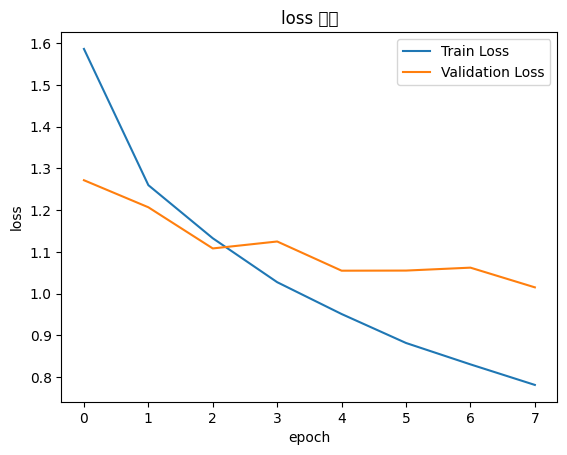

In [30]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['validation'], label='Validation Loss')
plt.title('loss 비교')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show

## 13. 정확도 평가

In [31]:
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=7)
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert")
model.load_state_dict(torch.load("new_data_test.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Test ####

model.to(device)
model.eval()

loss_test = 0.0
correct = 0
with torch.no_grad():
    for batch in test_loader:
        # gpu 보내기
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)
        # print(input_ids)
        # print(attention_mask)
        # print(token_type_ids)

        # 예측
        outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids,
        labels = labels 
        )
        
        loss = outputs.loss
        preds = outputs.logits.argmax(dim=1)
        correct += (labels == preds).sum()

        # loss 저장
        loss_test += loss.item() * batch_size
print(f"Test Loss: {loss_test / len(test_dataset)}, Accuracy: {correct / len(test_dataset)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1859832/1586481876.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

Test Loss: 1.0967900296619961, Accuracy: 0.6384999752044678


## 14. 예측

In [6]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer

# 모델 및 토크나이저 로드
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=7)
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert")
model.load_state_dict(torch.load("new_data_test.pth"))

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 입력 텍스트 토큰화
text = "공부했는데 잘 안돼, 너무 속상하네"
encoded_input = tokenizer(text, return_tensors="pt")
encoded_input = {key: val.to(device) for key, val in encoded_input.items()}

# 모델 호출 및 출력 처리
outputs = model(**encoded_input)
print(outputs.logits.argmax(dim=1).item())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1946046/2811949198.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

3
